# HCDS 512 Final Project
## Influential Characteristics of Opinion: A Basic Income Study
Released by: Ian Kirkman ikirkman@uw.edu 12/13/2017
    
## Introduction

We are in period of rapidly changing economies, and basic income is likely to become a necessity within our lifetimes. (Some would argue that it already is). Tracking public opinion on the matter is not limited to the interest of government or politic, but to any constituent that is aware of what automation and globalization mean for our future. Shaping public opinion of basic income will be a key component of making that transition as smooth as politically possible, while continuing to measure and predict that opinion will inform when success of implementation is feasible.

## Background and Related Work

My background on basic income has been merely a casual curiosity. I've come accross supportive blog posts from authors like Elon Musk, who are outspokenly in favor of basic income as the potential for automation to display workers is realized. I looked for actual experience data as well, but only found anectodal information about temporary test programs in basic income (where effects may not have been realized due to awareness of participants that the income was temporary), or need-based and restricted programs like the United States has.

I also found an out-of-date Wikipedia article disussing four class groups of European Social Welfare. I linked the article in the references, but I did not want to use the information because it was from 2003 and several places stated that it needed citation. Clicking through the sources did not turn up anywhere with those classifications. Despite not being able to find a credible source, I wondered if my K-means country classification would have alotted similar groupings. It turns out that it did not, even with some overfitting at k=4.

While I am generally sympathetic to socialist ideals, I identify that I may have a bias. I believe this was apparent in the phrasing and choice of hypothesis. However, I feel that I was open to results that countered my beliefs.

## Hypotheses

We anticipate that we will identify some correlated features to opinion of basic income, including features of the Dalia survey as well as features on from the supplemental country data.

From the Dalia survery data, we hypothesize that:
- Younger people will view basic income more favorably. We anticipate this because younger people are planning for a longer future, and have earning potential at stake as automation is replacing jobs.
- Urban-dwellers will view basic income more favorably. We anticipate this because urban dwelling tends to be more expensive, and workers are more likely involved in service economies than rural workers.
- People with children in their household will view basic income more favorably than those without. We anticipate this because people with children are likely to be anticipating the future on the behalf of their children.


From the supplemental data, we hypothesize that:
- Healthier countries will have a more favorable view overall of basic income. We posit that countries that are healthier have successfully implemented social care programs.
- Happier countries will have a more favorable view overall of basic income. We posit that happier countries are likely to have a culture of work/life balance that values life and social contributions beyond work.
- Economically burdened countries will have a more negative view overall of basic income. While counterintuitive that economically burdened countries may seek relief, we anticipate that signs of struggle may indicate failed social programs and/or negative views/blaming for failures.


## Methods



### 1. Data Prerequisites

Section 1 covers all the information needed to gather data, import the required libraries, and set user inputs. We start below with libraries and parameters. 

#### 1.1. Importing Libraries and Setting Parameters

This package includes the following libraries for processing and analysis:
 - `json`: This is used to format, save, and load raw data after it's pulled from the source.
 - `csv`: This is used to load raw data from csv files, and to write processed data to a csv. 
 - `math`: The function `ceil` is used to group subjects into 5-year age bands.
 - `matplotlib`: The `matplotlib` library is used to create visual representations of results. 
 - `seaborn`: The `seaborn` extension adds some additional features and options to `matplotlib`. 
 - `numpy`: Numpy arrays allow for fast data slicing and input to `pandas` Data Frames.
 - `pandas`: This is used to create Data Frames with specified dtypes to send to `seaborn` functions.
 - `sklearn': Features selection, K-Means Classification, and Data Standardization functions are imported from sci-kit learn for various parts of this analysis.
 
We have also included some plot settings in the opening section, in order to activate them throughout the workbook. The remaining user inputs are also set in this section, and referenced throughout the later processing steps. User inputs include input and output file path specifications. 

**Notes and Assumptions:**
- For all data paths it is assumed that this notebook lives in the project root directory. All paths should be written from the root.

In [1]:
# Import packages
import csv
import json
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sklearn.feature_selection as fs

# Plot Settings
%matplotlib inline
sns.set()
sns.set(style="ticks")

############ BEGIN USER INPUTS ###

github_username = 'iankirkman'
uw_email = 'ikirkman@uw.edu'
headers={'User-Agent' : 'https://github.com/%s'%github_username, 'From' : '%s'%uw_email}

###### FILE LOCATIONS ######

# Raw Data Locations
raw_bi_data_path = 'DATA/Dalia/basic_income_dataset_dalia.csv'
raw_country_data_path = 'DATA/country_codes_datahub.json'
raw_pop_data_path = 'DATA/GHDx/IHME_GBD_2016_POP_ESTIMATES/IHME_GBD_2016_POPULATION_ESTIMATES_2014_2016_Y2017M09D14.CSV'
raw_sdi_data_path = 'DATA/GHDx/IHME_GBD_2016_SDI_0/IHME_GBD_2015_SDI_1990_2016_VALUES_Y2017M09D14.csv'
raw_health_data_path = 'DATA/GHDx/IHME_RETROSPECTIVE_HEALTH_SPENDING_1995_2014/IHME_RETROSPECTIVE_HEALTH_SPENDING_1995_2014_Y2017M04D19.CSV'
raw_happy_data_path = 'DATA/world_happiness_2016.csv'
raw_yu_data_path = 'DATA/worldbank_API_ILO_country_YU.csv'

# Output File Locations
# TODO

############ END USER INPUTS ###

### 1.2 Raw Data Sources

Source and license information is documented below for each of the raw data files linked above. Limitations specific to each data set are noted as well.

**Dalia Basic Income Data:**
Raw [Basic Income Survey (2016)](/DATA/Dalia/basic_income_dataset_dalia.csv) data and [documentation](/DATA/Dalia/codebook_basicincome.pdf) codebook were accessed from [Kaggle](https://www.kaggle.com/daliaresearch/basic-income-survey-european-dataset), under the publicly available creative commons license [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

The 2016 Dalia survey data includes basic income opinion responses and demographic (age, gender, education level, full-time employment status, urban/rural residence, and presence of children in household) data for nearly 10K individual respondents in 28 EU countries. Age is limited to only 14-65, and gender is limited to only binary options with self-identification. Most features allow for only a single answer, however there are two opinion questions (for and against basic income) that allow for multiple selections of pre-determined phrases. 'NA' answers are allowed for education level, and 'None of the Above' is allowed on several opinion questions.

This study relies heavily on the demographic and survey data provided by Dalia, and almost all features are utilized. The population weight feature appears to have been gargled in the kaggle upload, so that is disregarded in our analysis. In order to create our own weights, we use the GHDx Population Estimates (see below). Since the population estimate file is in 5-year age bands, we will also ignore Dalia's age groupings in favor of creating our own buckets to map to GHDx.


**World Bank Youth Unemployment Rate Data:**
The [Youth Unemployment Rate](/DATA/worldbank_API_ILO_country_YU.csv) data was accessed form [Kaggle](https://www.kaggle.com/sovannt/world-bank-youth-unemployment) and is released under the World Bank's [Open License](https://data.worldbank.org/summary-terms-of-use). The most current year available on this dataset is 2014. It is also the only dataset in this project that uses 'Slovak Republic' instead of 'Slovakia'. 


**Sustainable Development Solutions Network World Happiness Report Data:**
The [World Happiness Report](/DATA/world_happiness_2016.csv) data was accessed from [Kaggle](https://www.kaggle.com/unsdsn/world-happiness) and is released under [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/). This dataset includes Happiness Score by country in the year 2016. The score was measured by asking a sample of people to rank their happiness from low to high on a scale of 0 to 10.


**Global Health Data Exchange (GHDx) Data:**
IHME's [Population Estimate](/DATA/GHDx/IHME_GBD_2016_POP_ESTIMATES/) data, [Socio-Demographic Index](/DATA/GHDx/IHME_GBD_2016_SDI_0/) data, and [Retrospective Health Spending](/DATA/GHDx/IHME_RETROSPECTIVE_HEALTH_SPENDING_1995_2014/) data were all accessed directly from the [Global Health Data Exchange](http://ghdx.healthdata.org), under the linked [terms and conditions](http://www.healthdata.org/about/terms-and-conditions). All GHDx datasets are publicly available under the [Open Data Commons Attribution License](https://opendatacommons.org/licenses/by/summary). Unused datasets (such as those representing historical year ranges) in each source folder were excluded from the github upload. However, all codebook and readme files from the original source are contained in each linked subfolder. 

The Socio-Demographic Index (SDI) dataset was converted from xlsx to csv format, using the export feature in Excel 2013. The most current year available is 2016. The SDI is a (0,1) index calculated from measures of weatlh, education and fertility rate. The [documentation](/DATA/GHDx/IHME_GBD_2016_SDI_0/README.txt) further explains, "SDI contains an interpretable scale: zero represents the lowest income per capita, lowest educational attainment, and highest TFR observed across all GBD geographies from 1970 to 2016, and one represents the highest income per capita, highest educational attainment, and lowest TFR." 

To allow for upload to github, the size of the Population Estimates dataset was manually restricted by limiting to only years 2014-2016. This restriction was done in Excel 2013 via Data > Filter > year_id > select [2014, 2015, 2016]. The restricted csv was saved under the same naming convention as the original dataset, with the 2014 replacing the start year. Population estimates are broken out into country, 5 year age band, and binary gender.

The features of interest in the Health Expenditures (2014) dataset include:
 - `the_per_gdp`: Total Health Expenditures per GDP by country
 - `the_per_cap`: Total Health Expenditures per Capita by country
 - `ghes_per_the`: Proportion of Total Health Expenditures paid by Government, for each country


**DataHub Country Codes:**
The [Country Code](/DATA/country_codes_datahub.json) json file was accessed from [datahub](https://datahub.io/core/country-list), and is released under the [Public Domain Dedication and License](https://opendatacommons.org/licenses/pddl/summary). This file is simply used to map the Dalia dataset country codes into the country names used on all other datasets.


### 1.3.a. Loading and Mapping Raw Dalia Data

The script below contains all the basic calls necessary to load the raw Dalia data from the specified path above. Later sections will depend on the variables defined below. 

The remainder of the raw data is global data, and we can greatly reduce the file size and computation by restricting on European Union countries. Therefore, we will process the Dalia BI data before proceeding with the rest of our uploads.

In [2]:
# Load Dalia Basic Income Survery Data
bi_raw = []
with open(raw_bi_data_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        bi_raw.append(row)         
# Put raw BI data into np array for more convenient slicing
bi_raw_np = np.asarray(bi_raw)
del bi_raw

# Load country abbreviation data into dictionary
c_map = {}
with open(raw_country_data_path, 'r') as infile:
    raw_cntry = json.load(infile)
    for i in range(len(raw_cntry)):
        c_map[raw_cntry[i]['Code']] = raw_cntry[i]['Name']

### 1.3.b. Mapping Raw Dalia Data

We start by creating a basic function to map raw Dalia ages into 5-year age bands to match the GHDx Population Estimate data. Note that we assume ages 14-65 only, due to limitations on the Dalia data.

Below, we define several dictionaries/lists to map possible Dalia data values (see the [codebook](/DATA/Dalia/codebook_basicincome.pdf) for further details). We map to ranked values and indicators in order to apply classification methods such as PCA, f_classif, and K-means. I used 'NA' for non-voters, 'NA' education level, and 'None of the Above' answers.

The 2 questions that allow multiple answers from 7 options are each expanded into 7 indicator values. The other opinion question regards how a subject believe their work would be affected by basic income being instituted. In addition to the 9 seperated codebook values, I considered similar groupings of the single-option answers to this question. My ranked work-choice mappings were:
 - 4: Stop working (includes codebook 1)
 - 3: Work less (includes codebook 2)
 - 2: Social replacement (rolls up codebook 3, and 4)
 - 1: New skill/career path (rolls up codebook 5,6, and 7)
 - 0: No effect (includes codebook 8)
 - NA: None of the above (includes codebook 9)

In [3]:
def age_grp_id(a):
    '''
    Calculates the 5-year age-band id in the GHDx Pop Est. Data.
    ID's are (See GHDx documentation):
        7: 10 to 14
        8: 15 to 19
        9: 20 to 24
        10: 25 to 29
        11: 30 to 34
        12: 35 to 39
        13: 40 to 44
        14: 45 to 49
        15: 50 to 54
        16: 55 to 59
        17: 60 to 64
        18: 65 to 69
        
    ASSUMPTIONS:
        Possible ages are limited to 14-65, such as the Dalia data.
        
    INPUT:
        a: the age as an integer.
        
    RETURNS: 
        The GHDx Population Estimate Age Group ID for age a.
    '''
    return math.ceil((a-14)/5)+7

###### DALIA DATA MAPPINGS ######

# See Codebook in DATA/Dalia folder
# Processed data uses ranked classifications wherever possible

g_map = {'male' : 1, 'female' : 0} # gender
u_map = {'urban' : 1, 'rural' : 0} # urban vs rural
fte_map = {'yes' : 1, 'no' : 0}    # employed full time
child_map = {'yes' : 1, 'no' : 0}  # children in residence

# education level
ed_map = {'high' : 3,              
          'medium' : 2,
          'low' : 1,
          'no' : 0,
          'NA' : 'NA'} 

# awareness of basic income
aware_map = {'I understand it fully' : 3,     
             'I know something about it' : 2,
             'I have heard just a little about it' : 1,
             'I have never heard of it' : 0}

# Create 3 vote groups: For, Against, Non-voter
vote_map = {'I would vote for it' : {'Cb_val':3,'Grp':1},
            'I would probably vote for it' : {'Cb_val':2,'Grp':1},
            'I would probably vote against it' : {'Cb_val':1,'Grp':0},
            'I would vote against it' : {'Cb_val':0,'Grp':0},
            'I would not vote' : {'Cb_val':'NA','Grp':'NA'}}

# Create ranked work-choice groupings:
    # 4: Stop working
    # 3: Work less
    # 2: Social replacement
    # 1: New skill/career path
    # 0: No effect
    # NA: None of the above
wc_map = {'‰Û_ stop working' : {'Desc':'Stop Work','Cb_val':1,'Grp':4},
          '‰Û_ work less' : {'Desc':'Work Less','Cb_val':2,'Grp':3},
          '‰Û_ do more volunteering work' : {'Desc':'Volunteer','Cb_val':3,'Grp':2}, 
          '‰Û_ spend more time with my family' : {'Desc':'Family','Cb_val':4,'Grp':2}, 
          '‰Û_ look for a different job' : {'Desc':'Different Job','Cb_val':5,'Grp':1},
          '‰Û_ work as a freelancer' : {'Desc':'Freelance','Cb_val':6,'Grp':1}, 
          '‰Û_ gain additional skills' : {'Desc':'Skills','Cb_val':7,'Grp':1},
          'A basic income would not affect my work choices' : {'Desc':'No Affect','Cb_val':8,'Grp':0},
          'None of the above' : {'Desc':'Other','Cb_val':9,'Grp':'NA'}}

# Override delimited text to abbrev lookup for support and against statements 
# Note that multiple choices are allowed and raw data is delimited with '|' 
# Lists are used to force alpha ordering of resultant abbreviations
support_list = [['A','It reduces anxiety about financing basic needs'],
                ['B','It creates more equality of opportunity'],
                ['C','It encourages financial independence and self-responsibility'],
                ['D','It increases solidarity, because it is funded by everyone'],
                ['E','It reduces bureaucracy and administrative expenses'],
                ['F','It increases appreciation for household work and volunteering'],
                ['G','None of the above']]

against_list = [['A','It is impossible to finance'],
                ['B','It might encourage people to stop working'],
                ['C','Foreigners might come to my country and take advantage of the benefit'],
                ['D','It is against the principle of linking merit and reward'],
                ['E','Only the people who need it most should get something from the state'],
                ['F','It increases dependence on the state'],
                ['G','None of the above']]

op_feat_map = {'SA':'It reduces anxiety about financing basic needs',
                'SB':'It creates more equality of opportunity',
                'SC':'It encourages financial independence and self-responsibility',
                'SD':'It increases solidarity, because it is funded by everyone',
                'SE':'It reduces bureaucracy and administrative expenses',
                'SF':'It increases appreciation for household work and volunteering',
                'SG':'None of the above (Support)',
                'AA':'It is impossible to finance',
                'AB':'It might encourage people to stop working',
                'AC':'Foreigners might come to my country and take advantage of the benefit',
                'AD':'It is against the principle of linking merit and reward',
                'AE':'Only the people who need it most should get something from the state',
                'AF':'It increases dependence on the state',
                'AG':'None of the above (Against)',
                'aware':'Self-ranked awareness',
                'wc_eff_grp':'Effects on Work Choice Grouped',
                'wc_eff_cb':'Effects on Work Choice'}

# NOTE: Dalia age groups and weights are overridden with GHDx Population Estimates data.


Now that we've defined how to process the Dalia data, we process as a numpy array for easy slicing in our later analysis.

In [4]:
# Build processed basic income data as numpy array
bi_uuid = np.asarray([[]])
bi_uuid_labels = np.asarray(['uuid','vote','vote_grp','cc','country',
                             'male','age','age_grp',
                             'urban','ed_lev','fte','child',
                             'aware','wc_eff_cb','wc_eff_grp',
                             'SA','SB','SC','SD','SE','SF','SG',
                             'AA','AB','AC','AD','AE','AF','AG'])

bi_uuid = np.vstack((bi_raw_np[1:,1], # direct uuid
                     [vote_map[i]['Cb_val'] for i in bi_raw_np[1:,9]], # mapped vote
                     [vote_map[i]['Grp'] for i in bi_raw_np[1:,9]], # mapped vote group
                     bi_raw_np[1:,0], # direct country_code
                     [c_map[i] for i in bi_raw_np[1:,0]], # mapped country name
                     [g_map[i] for i in bi_raw_np[1:,3]], # mapped gender
                     bi_raw_np[1:,2], # direct age
                     [age_grp_id(int(i)) for i in bi_raw_np[1:,2]], # mapped age_group
                     [u_map[i] for i in bi_raw_np[1:,4]], # mapped rural
                     [ed_map[i] for i in bi_raw_np[1:,5]], # mapped dem_education_level
                     [fte_map[i] for i in bi_raw_np[1:,6]], # mapped dem_full_time_job
                     [child_map[i] for i in bi_raw_np[1:,7]], # mapped dem_has_child
                     [aware_map[i] for i in bi_raw_np[1:,8]], # mapped aware
                     [wc_map[i]['Cb_val'] for i in bi_raw_np[1:,10]], # code-book mapping wc_eff_cb
                     [wc_map[i]['Grp'] for i in bi_raw_np[1:,10]], # grouped mapping wc_eff_grp
                     np.asarray([[int(c[1] in i) for c in support_list] for i in bi_raw_np[1:,11]]).T, #support statements
                     np.asarray([[int(c[1] in i) for c in against_list] for i in bi_raw_np[1:,12]]).T #against statements
                    )).T
 
del bi_raw_np
# Check dimensions
bi_uuid.shape

(9649, 29)

### 1.4. Loading Global Data

We can utilize `numpy.unique()` on the processed Dalia data to capture a list of EU countries to limit the remaining global data. This short series of scripts pulls in the rest of our source data. The variables defined below will be used throughout the remainder of our work.

### 1.4.a. Population Estimate Data

We reduce the size of the Population Estimate data by applying a restriction to just the values we need. In order, we restrict to EU countries, year is 2016, gender is only 'Male' or 'Female' (not 'Both'), and then age ranges are restricted to 5-year age bands between 15 and 64 (inclusive). Each step of this restriction can be reconciled and explored.

In [6]:
# Reference List to limit to EU countries only
eu_list = list(np.unique(bi_uuid[:,4]))

# Load Population Estimate Data
# Limit Pop data to 15-64, EU countries, 2016 only
pop_raw = []
with open(raw_pop_data_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        pop_raw.append(row)         
# Put raw Pop data into np array for more convenient slicing
pop_raw_np = np.asarray(pop_raw)
del pop_raw

# Apply Hierarchal Limitations: EU, year, sex, age group
ind_eu = [i for i in range(len(pop_raw_np)) if pop_raw_np[i,1] in eu_list]
pop_eu = np.asarray([list(pop_raw_np[i,:]) for i in ind_eu])

# Limit EU to 2016
ind_yr = [i for i in range(len(pop_eu)) if pop_eu[i,6]=='2016']
pop_yr = np.asarray([list(pop_eu[i,:]) for i in ind_yr])
del pop_eu

# Limit EU,2016 to Male, Female only
ind_sex = [i for i in range(len(pop_yr)) if pop_yr[i,3] in ('Male','Female')]
pop_sex = np.asarray([list(pop_yr[i,:]) for i in ind_sex])
del pop_yr

# Limit EU,2016,sex to age group id's 8-17 (15-64 in 5 year age bands)
ind_age = [i for i in range(len(pop_sex)) if int(pop_sex[i,4]) in range(8,18)]
pop_np = np.asarray([list(pop_sex[i,:]) for i in ind_age])
pop_np_lab = pop_raw_np[0,:]
del pop_raw_np
del pop_sex

#### 1.4.b. Health Expenditure Data

We reduce the size of the Health Expenditure data by applying a restriction to just the values we need. In order, we restrict to EU countries, year is 2014 (the most current), and then we restrict to just our three features of interest: Health Expenditures (HE) by GDP, HE per Capita, and Proportion of Total HE paid by Government. Each step of this restriction can be reconciled and explored.

Results are stored in a python dict to easily hash with other global datasets.

In [7]:
# Load GHDx Health Expenditure Data
# EU countries, 2014 (most current) only
the_raw = []
with open(raw_health_data_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        the_raw.append(row)         
# Put raw health data into np array for more convenient slicing
the_raw_np = np.asarray(the_raw)
del the_raw

# Apply Hierarchal Limitations: EU, year
# Limit to EU countries only
ind_eu = [i for i in range(len(the_raw_np)) if the_raw_np[i,1] in eu_list]
the_eu = np.asarray([list(the_raw_np[i,:]) for i in ind_eu])

# Limit EU to 2014 (the most current year on this dataset)
ind_yr = [i for i in range(len(the_eu)) if the_eu[i,4]=='2014']
the_yr = np.asarray([list(the_eu[i,:]) for i in ind_yr])
the_yr_lab = the_raw_np[0,:]
the_yr_lab, the_yr.shape
del the_raw_np
del the_eu

# Drop unneeded columns and store as dict
# {location_name: {the_per_gdp: , the_per_cap, ghes_per_the}}
# {country:{Health Exp. per GDP, Health Exp. per Capita, Govmt portion of total health exp.}}
the = {}
for row in the_yr:
    the[row[1]] = {}
    the[row[1]]['the_per_gdp'] = float(row[6])
    the[row[1]]['the_per_cap'] = float(row[7])
    the[row[1]]['ghes_per_the'] = float(row[8])
del the_yr

#### 1.4.c. Socio-Demographic Index Data

We reduce the size of the SDI data by applying a restriction to just the values we need. In order, we restrict to EU countries, year is 2016 (the most current). Each step of this restriction can be reconciled and explored.

Results are stored in a python dict to easily hash with other global datasets.

**Note:** This csv file has extra headers at the top. Start reading at line 3.

In [9]:
# Load GHDx Socio-Demographic Data
# Start Reading on row 3
# EU countries, 2016 (most current-- found in last column) only
sdi_raw = []
with open(raw_sdi_data_path) as csvfile:
    reader = csv.reader(csvfile)
    i = 0 # to slice the header off
    for row in reader:
        i += 1
        if i > 2:
            sdi_raw.append(row)        

# Put raw sdi data into np array for more convenient slicing
sdi_raw_np = np.asarray(sdi_raw)
sdi_raw_np[0,:]
del sdi_raw

# Limit to EU countries only
ind_eu = [i for i in range(len(sdi_raw_np)) if sdi_raw_np[i,0] in eu_list]
sdi_eu = np.asarray([list(sdi_raw_np[i,:]) for i in ind_eu])
del sdi_raw_np

# Pull 2016 SDI's into dictionary {country:SDI}
sdi = {}
for row in sdi_eu:
    sdi[row[0]] = float(row[-1])
del sdi_eu

#### 1.4.d. World Happiness Data

We reduce the size of the World Happiness data by applying a restriction to just the values we need. In order, we restrict to EU countries, then we pull only the Happiness Score feature and country name from the dataset. The happiness scores are normalized against the rest of the EU scores in order to obtain values in (0,1) with 0 low and 1 high, so they are scaled and easily comparable with other data points suchs as SDI, rate of government health coverage, and youth *employment* rate. Each step of this restriction can be reconciled and explored.

Results are stored in a python dict to easily hash with other global datasets.

**Note:** Scores are normalized against EU scores to (0,1) representing (low,high) happiness. 

In [11]:
# Load World Happiness Data
# EU countries, 2016 reflected in dataset selection
hap_raw = []
with open(raw_happy_data_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        hap_raw.append(row)        
            
# Put raw happiness data into np array for more convenient slicing
hap_raw_np = np.asarray(hap_raw)
hap_raw_np[0,:]
del hap_raw

# Limit to EU countries only
ind_eu = [i for i in range(len(hap_raw_np)) if hap_raw_np[i,0] in eu_list]
hap_eu = np.asarray([list(hap_raw_np[i,:]) for i in ind_eu])

# Pull 2016 Normalized (0,1) Happiness Scores into dictionary {country:SDI}
happy_score_nrml = {}
hmax = np.max([float(hap_eu[i,3]) for i in range(len(hap_eu))])
hmin = np.min([float(hap_eu[i,3]) for i in range(len(hap_eu))])
for row in hap_eu:
    happy_score = float(row[3])
    happy_score_nrml[row[0]] = (happy_score-hmin)/(hmax-hmin)

del ind_eu
del hap_eu
del hap_raw_np

#### 1.4.c. Youth Unemployment Rate Data

We reduce the size of the Youth Unemployment Rate data by applying a restriction to just the values we need. In order, we restrict to EU countries, then we pull only the 2014 rate and find the YER by subtracting it from 1. As such we are able to obtain values in (0,1) with 0 low and 1 high for Youth Employment (positive), so they are scaled and easily comparable with other data points suchs as SDI, rate of government health coverage, and normalized happiness score. Each step of this restriction can be reconciled and explored.

Results are stored in a python dict to easily hash with other global datasets.

**Notes:**
- 2014 is the most current year available.
- `YER` or Youth Employment Rate is saved so that (0,1) represents (low youth employment rate, high youth employment rate).
- Country name for 'Slovak Republic' on this dataset needs to be overriden to match 'Slovakia' on the rest of the datasets.

In [12]:
# Load Youth Unemployment Data
# EU countries, 2014 is most current year
# Watch out that Slovak_Republic = Slovakia on all other data
yu_raw = []
with open(raw_yu_data_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        yu_raw.append(row)        
            
# Put raw youth unemployment data into np array for more convenient slicing
yu_raw_np = np.asarray(yu_raw)
yu_raw_np[0,:]
del yu_raw

# Limit to EU countries only - override here
eu_list = list(np.unique(bi_uuid[:,4])) + ['Slovak Republic']
ind_eu = [i for i in range(len(yu_raw_np)) if yu_raw_np[i,0] in eu_list]
yu_eu = np.asarray([list(yu_raw_np[i,:]) for i in ind_eu])

# Note: Switching to Youth Employment Rate so high values better
# Pull 2014 YER's into dictionary {country:YER}
yer = {}
for row in yu_eu:
    if row[0]=='Slovak Republic':
        yer['Slovakia'] = 1 - float(row[-1])/100
    else:
        yer[row[0]] = 1 - float(row[-1])/100

del yu_raw_np
del ind_eu
del yu_eu

## 2. Processing Data

### 2.a. Aggregate European Union Survey Data

In this section, we will prepare several slices of the aggregate Dalia data for further analysis. Voter groups are rolled up into support, oppose, or not voting. 

**Notes:** 
 - Subjects with 'NA' values for education level are removed from all slices except initial X,Y. 
 - Data is split into separate demographic and opinion subsets at each level.
 - Naming convention _vt3 represents 3 voter types (support, oppose, non-voter), and vt2 represents support and oppose only. The raw Dalia set has 5 voter categories, but we have rolled up both 'I would probably [not] vote for it' and 'I would [not] vote for it' into their respective support/[oppose] categories.
 - Response array (Y_xx) is the designated voter group.
 - Predictor matrices (X_xx) have a matching array of feature labels named X_xx_lab.

In [13]:
## Aggregate EU Data Slices - Initial X,Y

# Create matrix X of Quantitative Predictors
# And response classes Y of vote group
X = bi_uuid[:,5:]
X_lab = bi_uuid_labels[5:]
Y = bi_uuid[:,2] # 3 vote groups: for, against, not voting

The largest slice (X_vt3,Y_vt3) includes non-voters. All subjects with any 'NA' predictor value have been removed from the _vt3 data slices:

In [14]:
# Remove NAs from predictors and their corresponding responses
# Full predictor matrix and response with 3 vote classes
na_ind_removed = [i for i in range(len(X)) if 'NA' not in X[i,:]]
X_vt3 = np.asarray([list(X[i,:]) for i in na_ind_removed])
Y_vt3 = np.asarray([Y[i] for i in na_ind_removed])
del X
del Y

Split X_vt3 into subsets of demographic and opinion predictors:

In [15]:
# Subset of demographic predictors only - 3 vote classes
X_dem_vt3 = X_vt3[:,:7]
X_dem_vt3_lab = X_lab[:7]

# Subset of opinion predictors only - 3 votes classes
X_op_vt3 = X_vt3[:,7:]
X_op_vt3_lab = X_lab[7:]

For the next slice (X_vt2,Y_vt2), we simply remove non-voters:

In [16]:
# Restrict Data to only voters
ind_voters = np.where(Y_vt3!='NA')
Y_vt2 = Y_vt3[ind_voters]
X_vt2 = np.asarray([list(X_vt3[i,:]) for i in ind_voters][0])

And once again, we split the resulting matrix into subsets of demographic and opinion predictors:

In [17]:
# Subset of demographic predictors only - non-voters excluded
X_dem_vt2 = X_vt2[:,:7]
X_dem_vt2_lab = X_lab[:7]

# Subset of opinion predictors only - non-voters excluded
X_op_vt2 = X_vt2[:,7:]
X_op_vt2_lab = X_lab[7:]

Only demographic data is needed for the subsets of non-voters (X_vtN,Yvt_N) and of voters that are opposed (X_vto,Y_vto).

In [18]:
# Restrict Data to only non-voters
ind_nonvoters = np.where(Y_vt3=='NA')
Y_vtN = Y_vt3[ind_nonvoters]
X_vtN = np.asarray([list(X_vt3[i,:]) for i in ind_nonvoters][0])

# Subset of demographic predictors only - non-voters only
X_dem_vtN = X_vtN[:,:7]
X_dem_vtN_lab = X_lab[:7]

In [19]:
# Restrict Data to only opposed
ind_opposed = np.where(Y_vt3=='0')
Y_vto = Y_vt3[ind_opposed]
X_vto = np.asarray([list(X_vt3[i,:]) for i in ind_opposed][0])

# Subset of demographic predictors only - opposed only
X_dem_vto = X_vto[:,:7]
X_dem_vto_lab = X_lab[:7]

### 2.b. Basic Income Weighted Support by Country 

We will first calculate sample population weights for the Dalia dataset by taking the GHDx Populations Estimates as true values. As we are limited by the GHDx data, population weights will be calculated to binary gender and 5-year age band by country. Since Dalia includes 14 and 65 year-olds which would be alone in the 10-14 and 65-69 groups, we have removed the 14 and 65 year olds from the combined data. We also limit the Dalia data to exclude non-voters so we can calculate a proportion of support from each country with the rolled up, weighted values.

To calculate the weights, we find the true population proportion of every age/gender cell in each country, and divide that by the sample population proportion in the same cell.

The voters and in favor and against basic income are summed to each cell level and multiplied by their weight. Then the weighted support and oppose values are summed to the country level, and a proportion of support for that country is established by dividing the sum of weighted support by the sum of the weighted combined total.

In [20]:
# Create Population Weights

# At gender, 5-year age band level, find
# proportion of country population.

# Get population totals by country
cntry_pop_tots = {}
for row in pop_np:
    if row[1] in cntry_pop_tots:
        cntry_pop_tots[row[1]] += float(row[7])
    else:
        cntry_pop_tots[row[1]] = float(row[7])

# Find age/gender proportions of country populations
# Store in dict {country:{sex_id:{age_grp:pop_prp}}}
pop_prps = {}
for i in range(len(pop_np)):
    if pop_np[i,1] not in pop_prps: # brand new
        pop_prps[pop_np[i,1]] = {} # add country dict
    if str(int(pop_np[i,2])%2) not in pop_prps[pop_np[i,1]]: # male dict not in country dict
        pop_prps[pop_np[i,1]][str(int(pop_np[i,2])%2)] = {} # add sex_id dict
    
    pop_prps[pop_np[i,1]][str(int(pop_np[i,2])%2)][pop_np[i,4]] = float(pop_np[i,7])/cntry_pop_tots[pop_np[i,1]] # set proportion value at age band dict
 

## IMPORTANT NOTE:
# Limit Dalia data to only voters and those with 
# age_grp id's 8 through 17 (throw out 14 and 65 year olds)

# Count Dalia uuid's by male, age_grp for each country
# Get sample totals by country
cntry_samp_tots = {}
for row in bi_uuid:
    if (row[1] != 'NA' and row[7] not in ('7','18')):
        if row[4] in cntry_samp_tots:
            cntry_samp_tots[row[4]] += float(1)
        else:
            cntry_samp_tots[row[4]] = float(1)
    else:
        continue

# Find age/gender counts of country sample pops
# Store counts in dict: {country:{sex_id:{age_grp:samp_count}}}
samp_cts = {}
for i in range(len(bi_uuid)):
    if (bi_uuid[i,1] != 'NA' and bi_uuid[i,7] not in ('7','18')):
        if bi_uuid[i,4] not in samp_cts: # brand new
            samp_cts[bi_uuid[i,4]] = {} # add country dict
        if bi_uuid[i,5] not in samp_cts[bi_uuid[i,4]]: # male dict not in country dict
            samp_cts[bi_uuid[i,4]][bi_uuid[i,5]] = {} # add sex_id dict
        if bi_uuid[i,7] not in samp_cts[bi_uuid[i,4]][bi_uuid[i,5]]:
            # Set new count value
            samp_cts[bi_uuid[i,4]][bi_uuid[i,5]][bi_uuid[i,7]] = {'supp':0, 'opp':0, 'ct':1}
            if bi_uuid[i,2] == '1':
                samp_cts[bi_uuid[i,4]][bi_uuid[i,5]][bi_uuid[i,7]]['supp'] += float(1)
            else: # NA's already excluded so just add to opp
                samp_cts[bi_uuid[i,4]][bi_uuid[i,5]][bi_uuid[i,7]]['opp'] += float(1)
        else:
            # Add to count value
            samp_cts[bi_uuid[i,4]][bi_uuid[i,5]][bi_uuid[i,7]]['ct'] += float(1)
            if bi_uuid[i,2] == '1':
                samp_cts[bi_uuid[i,4]][bi_uuid[i,5]][bi_uuid[i,7]]['supp'] += float(1)
            else: # NA's already excluded so just add to opp
                samp_cts[bi_uuid[i,4]][bi_uuid[i,5]][bi_uuid[i,7]]['opp'] += float(1)
    else:
        continue # do nothing if age 14, 65 or a non-voter
    
# Calculate Sample proportions and weight = pop_prp/samp_prp
# Store in dict: {country{sex{age{weight}}}}
samp_wt = {}
for country in samp_cts.keys():
    samp_wt[country] = {}
    for sex in samp_cts[country].keys():
        samp_wt[country][sex] = {}
        for ag in samp_cts[country][sex].keys():
            samp_prp = float(samp_cts[country][sex][ag]['ct'])/float(cntry_samp_tots[country])
            pop_prp = pop_prps[country][sex][ag]
            weight = pop_prp/samp_prp
            samp_wt[country][sex][ag] = weight

            
# Multiply weight by vote_for and vote_against counts.
for country in samp_cts.keys():
    for sex in samp_cts[country].keys():
        for ag in samp_cts[country][sex].keys():
            samp_cts[country][sex][ag]['w_supp'] = samp_wt[country][sex][ag] * \
                                                samp_cts[country][sex][ag]['supp']
            samp_cts[country][sex][ag]['w_opp'] = samp_wt[country][sex][ag] * \
                                                samp_cts[country][sex][ag]['opp']


# Sum weighted vote counts to country level.
# Store in dict {country:{sum_w_opp,sum_w_supp}}
wt_cntry = {}
for country in samp_cts.keys():
    for sex in samp_cts[country].keys():
        for ag in samp_cts[country][sex].keys():
            if country in wt_cntry: # just add to totals
                wt_cntry[country]['sum_w_opp'] += samp_cts[country][sex][ag]['w_opp']
                wt_cntry[country]['sum_w_supp'] += samp_cts[country][sex][ag]['w_supp']
            else: # add new country key
                wt_cntry[country] = {}
                wt_cntry[country]['sum_w_opp'] = samp_cts[country][sex][ag]['w_opp']
                wt_cntry[country]['sum_w_supp'] = samp_cts[country][sex][ag]['w_supp']
                
# Calculate weighted proportion of voter support in each country
wt_prp_supp = {}
for country in wt_cntry.keys():
    wt_prp_supp[country] = wt_cntry[country]['sum_w_supp']/ \
                (wt_cntry[country]['sum_w_supp']+wt_cntry[country]['sum_w_opp'])

### 2.c. Combining Country Indices in a Single Data Frame

By design, our country summary indices are easily hashed together from Python dictionaries into a pandas data frame. 

In [21]:
cd = []
for country in wt_prp_supp.keys():
    cd.append((country,
               wt_prp_supp[country],
               sdi[country],
               happy_score_nrml[country],
               the[country]['ghes_per_the'],
               the[country]['the_per_gdp'],
               the[country]['the_per_cap'],
               yer[country]))
dtype = [('Country',object),('Pct_Supp_BI','f4'),('SDI','f4'),
         ('Nrml_H_Score','f4'),('Pct_Govt_HE','f4'),
         ('THE_GDP','f4'),('THE_Cap','f4'),('YER','f4')]
a = np.array(cd, dtype=dtype)
df = pd.DataFrame(a)
df

,Country,Pct_Supp_BI,SDI,Nrml_H_Score,Pct_Govt_HE,THE_GDP,THE_Cap,YER
0,Austria,0.653759,0.8922,0.877002,0.779853,0.111880,5471.085938,0.908
1,Belgium,0.682517,0.8988,0.819583,0.779056,0.105897,4750.610840,0.764
2,Bulgaria,0.897118,0.8461,0.000000,0.546806,0.084245,1490.361328,0.741
3,Cyprus,0.893807,0.8718,0.401632,0.460323,0.072384,2019.437622,0.643
4,Czech Republic,0.474060,0.8811,0.718948,0.848322,0.073851,2383.707764,0.833
5,Germany,0.655065,0.8887,0.839226,0.773424,0.112451,5356.443359,0.924
6,Denmark,0.542436,0.9253,1.000000,0.847642,0.108050,5074.840332,0.876
7,Estonia,0.899748,0.8874,0.392868,0.789735,0.063672,1830.080078,0.830
8,Spain,0.773756,0.8482,0.647930,0.710869,0.090030,3095.679932,0.421
9,Finland,0.816774,0.9071,0.965851,0.780177,0.093438,3934.596436,0.808


## Findings

### 1. Aggregate EU Survery Data - Demographics

The aggregate European Union data is useful for exploring overall support by demographic. We are able to create some meaningful visualizations so the curious party can dissect the confounding factors contributing to a vote in favor or against basic income. 

#### 1.a. Excluding Non-Voters Impacts Young
The aggregate data also allows us to get a sense of who may be excluded from the country index for being a non-voter. A few visualizations on our data slices show below that the demographic most impacted by the exclusion of non-voters are young people. While some may be too young to legally vote (e.g.: 15-19 age band), the skew is clearly present up until the early thirties, as seen below:

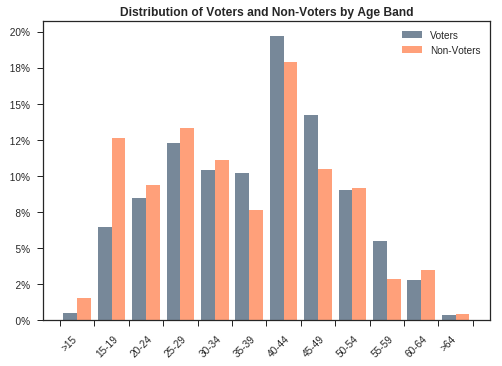

In [22]:
# Demographics of Voters versus Non-Voters

# Age band comparison
nv_agebands = [int(X_dem_vtN[i,2]) for i in range(len(X_dem_vtN))]
v_agebands = [int(X_dem_vt2[i,2]) for i in range(len(X_dem_vt2))]
ageband_labs = ['>15','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','>64']

bns = [i for i in range(7,20)]
fig,ax = plt.subplots()
plt.hist([v_agebands,nv_agebands], normed=True, bins=bns, histtype='bar',
                            label=['Voters','Non-Voters'],
                            color=['lightslategray','lightsalmon'])
plt.xticks(bns,ageband_labs, rotation=45, va='top', ha='left')

yvals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])

ax.set_title('Distribution of Voters and Non-Voters by Age Band', fontweight='bold')
ax.legend()
plt.show()

#### 1.b. Young Support Basic Income

We see a similar yet less significant skew in the graph of support versus oppose (excluding non-voters) by age band. This suggests that the country index data is underestimating the proportion of support, if we assume that non-voting young people skew toward supporting basic income.

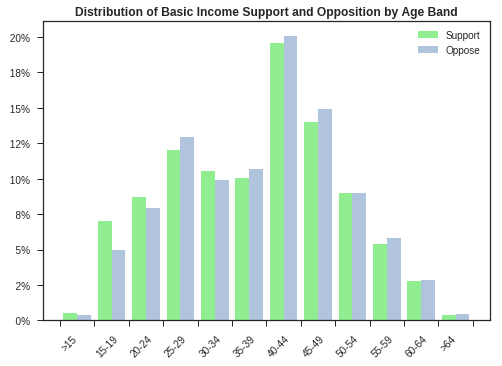

In [23]:
# Voter Demographics Support vs. Against

# Age band comparison
supp_agebands = [int(X_dem_vt2[i,2]) for i in range(len(X_dem_vt2)) if Y_vt2[i]=='1'] # support
against_agebands = [int(X_dem_vt2[i,2]) for i in range(len(X_dem_vt2)) if Y_vt2[i]=='0'] # against
ageband_labs = ['>15','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','>64']

bns = [i for i in range(7,20)]
fig,ax = plt.subplots()
plt.hist([supp_agebands,against_agebands], normed=True, bins=bns, histtype='bar',
                            label=['Support','Oppose'],
                            color=['lightgreen','lightsteelblue'])
plt.xticks(bns,ageband_labs, rotation=45, va='top', ha='left')

yvals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])

ax.set_title('Distribution of Basic Income Support and Opposition by Age Band',fontweight='bold')
ax.legend()
plt.show()

#### 1.c. Other Demographic Factors

Full-time Employment and Education Level also have significant impact on basic income opinion. However, it is worth noting that there is only a small representation (<3%) in the 'None' designation for education level. 

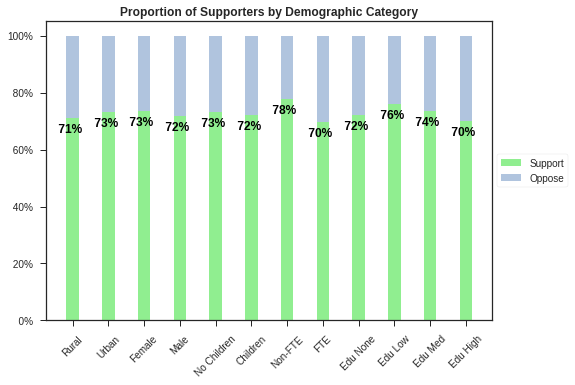

In [25]:
# All other demographic support vs oppose comparison
def get_prpn_s_o(col):
    '''
    Dummy function to pull support and oppose proportions of total voters.
    Excludes non-voters.
    
    Input: 
        col: the column to pull frequencies on
    
    Returns:
        (support,oppose) tuple of lists of frequency for each 
                    value (increasing key order to index) represented in col.
    '''
    # get total counts - voters only
    tu, tc = np.unique(X_dem_vt2[:,col], return_counts=True)
    t = dict(zip(tu,tc))
    
    # get total oppose counts
    ou, oc = np.unique(X_dem_vto[:,col], return_counts=True)
    o = dict(zip(ou,oc))
    
    sprp = []
    oprp = []
    for k in t.keys():
        if k != 'NA':
            if k in o.keys():
                sprp.append((t[k]-o[k])/t[k])
                oprp.append(o[k]/t[k])
            else: 
                sprp.append(1)
                oprp.append(0)
    return sprp,oprp

# Get all proportions by column
so_urb = get_prpn_s_o(3)
so_gen = get_prpn_s_o(0)
so_ch = get_prpn_s_o(6)
so_ft = get_prpn_s_o(5)
so_edu = get_prpn_s_o(4)

# Append into lists in label-order
s_dem_prps = so_urb[0] + so_gen[0] + so_ch[0] + so_ft[0] + so_edu[0]
o_dem_prps = so_urb[1] + so_gen[1] + so_ch[1] + so_ft[1] + so_edu[1]

# plotting params
ind = np.arange(12) 
width = 0.35       

comp_labs = ['Rural', # Col 3, Val 0
             'Urban', # Col 3, Val 1
             'Female', # Col 0, Val 0
             'Male', # Col 0, Val 1
             'No Children', # Col 6, Val 0
             'Children', # Col 6, Val 1
             'Non-FTE', # Col 5, Val 0
             'FTE', # Col 5, Val 1
             'Edu None', # Col 4, Val 0
             'Edu Low', # Col 4, Val 1
             'Edu Med', # Col 4, Val 2
             'Edu High'] # Col 4, Val 3, Note: Excludes NA Ed level

fig,ax = plt.subplots()
p1 = ax.bar(ind, s_dem_prps, width, label='Support',color='lightgreen')
p2 = ax.bar(ind, o_dem_prps, width, label='Oppose',color='lightsteelblue',
             bottom=s_dem_prps)

ax.set_title('Proportion of Supporters by Demographic Category', fontweight='bold')
plt.xticks(ind, comp_labs,rotation=45)

yvals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])

ax.legend(frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))

for i, v in enumerate(s_dem_prps):
    ax.text(i-.5, v -.05, '{:3.0f}%'.format(s_dem_prps[i]*100), color='black', fontweight='bold')

plt.show()

In [26]:
# Find percent of voters with Education Level = 'None':
'Percent of Voters with "None" Education Level: {:3.2f}%'.format(len(np.where(X_dem_vt2[:,4]=='0')[0])/len(X_dem_vt2)*100)

'Percent of Voters with "None" Education Level: 2.78%'

## 2. Aggregate Data - Using Classifier Scores to Select Impactful Features

After attempts with PCA and K-means that were discarded for lack of meaningful results, we were able to identify features with the greatest impact on voter support or opposition through scikit-learn's SelectKBest function scoring. We chose the f_classif method because the variables are either categorical, or can easily be interpreted that way.

Scikit-learn returns a list of scores and corresponding p_values for the top scoring `k` features. In each case, we ran the function for `k` equal to the number of all features and collected a ranked list of every feature by score for that had p-value > 0.05. Therefore, the list of features is significantly ordered by greatest impact to voter support or opposition.

First, we can use this method to confirm our findings on the demographic data:

In [27]:
# Most Influential Demographic Factors on Voter Outcome (Non-voters excluded)
# Recursive F_Classif classification
# Ranked by feature impact with significance level <.05
# Output is (Feature, p-value)
kbest_dem = fs.SelectKBest(fs.f_classif,k=len(X_dem_vt2_lab))
Z_dem_vt2 = kbest_dem.fit_transform(X_dem_vt2,Y_vt2)
featscor_dem = kbest_dem.scores_
[X_dem_vt2_lab[i] for i in featscor_dem.argsort()[::-1] if kbest_dem.pvalues_[i]<.05]

['fte', 'ed_lev', 'age', 'age_grp']

Now we can apply the same method to find out which opinion statements are the strongest indicators of voter support or opposition:

In [30]:
# Most Influential Opinion Statements on Voter Outcome (Non-voters excluded)
# Recursive F_Classif classification
# Ranked by feature impact with significance level <.05
# Output is (Feature, p-value)
kbest_op = fs.SelectKBest(fs.f_classif,k=len(X_op_vt2_lab))
Z_op_vt2 = kbest_op.fit_transform(X_op_vt2,Y_vt2)
featscor_op = kbest_op.scores_
[(X_op_vt2_lab[i],op_feat_map[X_op_vt2_lab[i]]) for i in featscor_op.argsort()[::-1] if kbest_op.pvalues_[i]<.05]

[('SG', 'None of the above (Support)'),
 ('AD', 'It is against the principle of linking merit and reward'),
 ('SB', 'It creates more equality of opportunity'),
 ('SC', 'It encourages financial independence and self-responsibility'),
 ('SD', 'It increases solidarity, because it is funded by everyone'),
 ('SA', 'It reduces anxiety about financing basic needs'),
 ('AB', 'It might encourage people to stop working'),
 ('AA', 'It is impossible to finance'),
 ('SF', 'It increases appreciation for household work and volunteering'),
 ('AF', 'It increases dependence on the state'),
 ('AE',
  'Only the people who need it most should get something from the state'),
 ('aware', 'Self-ranked awareness'),
 ('wc_eff_grp', 'Effects on Work Choice Grouped'),
 ('AG', 'None of the above (Against)'),
 ('wc_eff_cb', 'Effects on Work Choice'),
 ('AC',
  'Foreigners might come to my country and take advantage of the benefit'),
 ('SE', 'It reduces bureaucracy and administrative expenses')]

What the above is really pointing out is that the early list entries are the most divisive in terms of voter support/opposal, and not necessarily indicating an 'ON' or 'OFF' value for the indicator. Therefore, it is not surprising that not agreeing with any supportive statements would be indicative of opposal. It is interesting however, that not agreeing with any opposal statements is so low in the ranking. It appears that even supportive voters would caveat to some negative aspects of basic income.

## 3. Grouping Similar Countries

We can apply K-means on the set of country features to find groups of similarly-advantaged countries. With only 28 countries, we were limited to a small k. 4 seemed to be overfitting, whereas 2 or 3 were ideal. In this case, we have a pretty clear split with k=2. We can further inspect the featuer interaction for each country group below.

In [70]:
# Groupings of Countries by feature

# Create a dataframe without Country name
cd_km = []
for country in wt_prp_supp.keys():
    cd_km.append((wt_prp_supp[country],
               sdi[country],
               happy_score_nrml[country],
               the[country]['ghes_per_the'],
               the[country]['the_per_gdp'],
               the[country]['the_per_cap'],
               yer[country]))
dtype_km = [('Pct_Supp_BI','f4'),('SDI','f4'),
         ('Nrml_H_Score','f4'),('Pct_Govt_HE','f4'),
         ('THE_GDP','f4'),('THE_Cap','f4'),('YER','f4')]
a_km = np.array(cd_km, dtype=dtype_km)
df_km = pd.DataFrame(a_km)

# Apply a K-means test to categories similar countries
np.random.seed(1111)
nm = 2
kmc = KMeans(nm)
kmc.fit(df_km)
kmc_pred = kmc.predict(df_km)
g,c = np.unique(kmc_pred,return_counts=True)
dict(zip(g,c))

{0: 17, 1: 11}

## 4. Pairwise Plotting of Country Index Values

We can reference our country index data frame with seaborn options to compare how basic income support correlates with other country indices. And we can use our K-means mapping to set a hue.

**Reference:** https://seaborn.pydata.org/tutorial/axis_grids.html

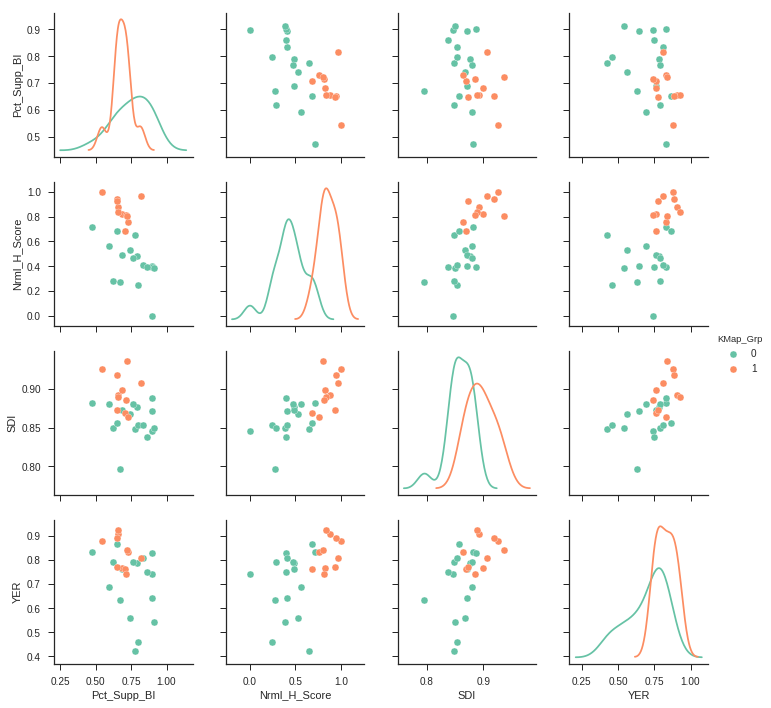

In [71]:
# Build data frame with k-means group mapped
cd_kmap = []
ind = 0
for country in wt_prp_supp.keys():
    cd_kmap.append((country,
                    kmc_pred[ind],
                    wt_prp_supp[country],
                    sdi[country],
                    happy_score_nrml[country],
                    the[country]['ghes_per_the'],
                    the[country]['the_per_gdp'],
                    the[country]['the_per_cap'],
                    yer[country]))
    ind += 1
dtype_kmap = [('Country',object),('KMap_Grp','i4'),('Pct_Supp_BI','f4'),('SDI','f4'),('Nrml_H_Score','f4'),('Pct_Govt_HE','f4'),('THE_GDP','f4'),('THE_Cap','f4'),('YER','f4')]
a_kmap = np.array(cd_kmap, dtype=dtype_kmap)
pd_kmap = pd.DataFrame(a_kmap)

# Support, Happy, SDI, YER
sns.pairplot(pd_kmap, 
             vars=["Pct_Supp_BI","Nrml_H_Score","SDI","YER"], 
             palette="Set2", 
             diag_kind="kde",
             hue="KMap_Grp")

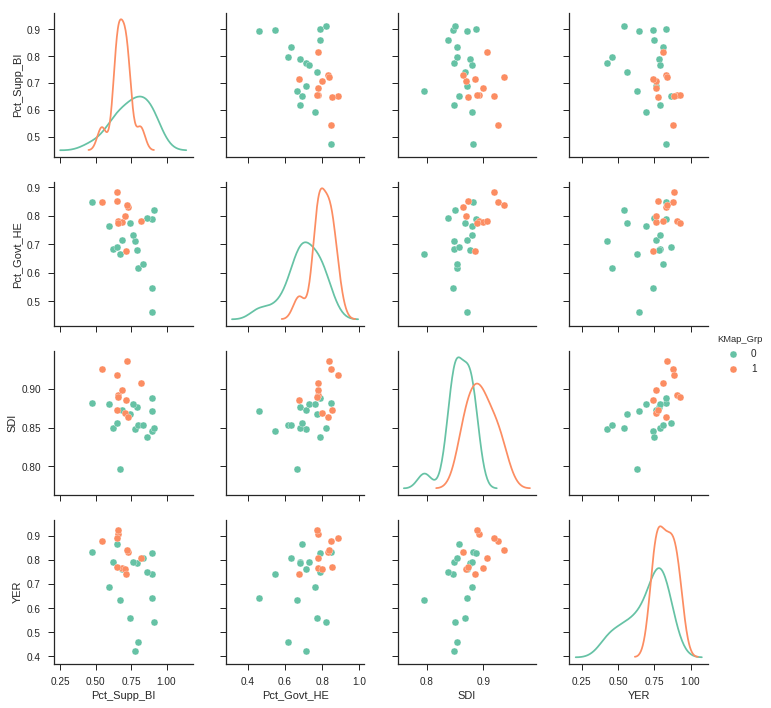

In [72]:
# Support, Govt_THE, SDI, YER
sns.pairplot(pd_kmap, 
             vars=["Pct_Supp_BI","Pct_Govt_HE","SDI","YER"], 
             palette="Set2", 
             diag_kind="kde",
             hue="KMap_Grp")

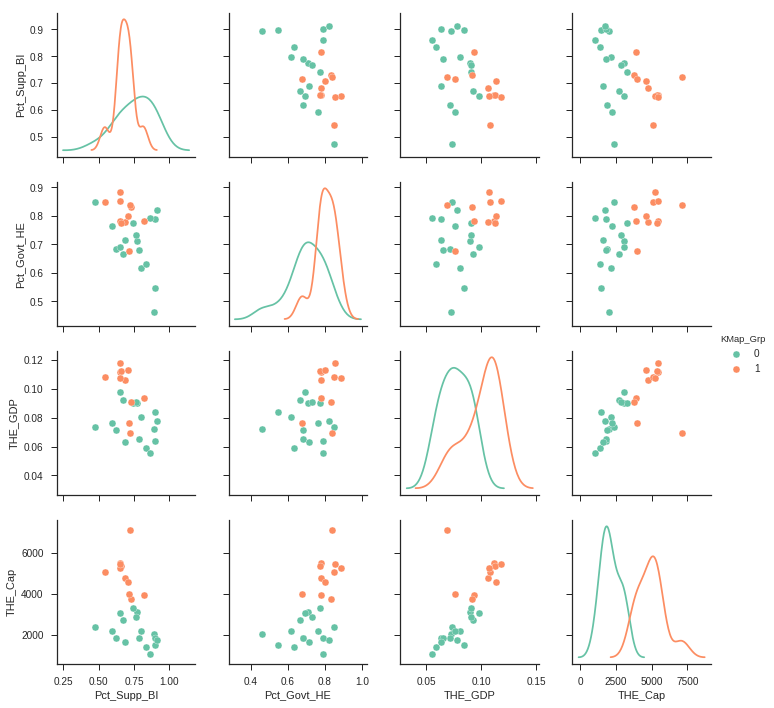

In [73]:
# Support, Govt_THE, THE_GDP, THE_Cap
sns.pairplot(pd_kmap, 
             vars=["Pct_Supp_BI","Pct_Govt_HE","THE_GDP","THE_Cap"], 
             palette="Set2", 
             diag_kind="kde",
             hue="KMap_Grp")

Working with these three different pairplot views, we see that while SDI, YER, Government coverage of health cost, and happiness rating all move positively together, there is an apparent inverse correlation between these measures and support for basic income. 

Furthermore, we observe that the scatterplots and histogram modalities show good separation of our K-means categories.

## Discussion/Implications

It is interesting to observe that happier countries with broader social services programs do not support basic income as highly as those that are suffering under relative economic, health and happiness factors. It seems that those in worse situations support basic income as a potential source of relief, while more comfortable people may have more apprehensions. 

I would like to see some future research include time series analysis to observe trends once Dalia releases data from additional years. I would also like to see the opinion motivations tied back to the country index features.

## Limitations

Several data limitations were listed in the relevant sections. In particular, the core survey dataset contained only ages 14-65, and only binary genders. Additionally, we had to drop ages 14 and 65 to fit to the GHDx data. A final major issue with combining the datasets is that the most current years were not consistent.

I decided against using a dataset that I initially planned to because it was too sparsely filled and poorly documented. The Dalia-calculated weights seem to be corrupt on the Kaggle website. Dalia also hosts another version but the license was more restrictive so I couldn't use it.

## Conclusion

Restating our hypothesis,
- We found data to support the hypothesis that younger people will view basic income more favorably.
- We found evidence that urban-dwellers will viewed basic income only slightly more favorablythan rural-dwellers.
- We did not find significant evidence that people with children in their household view basic income more favorably than those without.
- Contrary to our hypothesis, we found that more health-burdened countries have a more favorable view overall of basic income. 
- Contrary to our hypothesis, we found that happier countries have a less favorable view overall of basic income. 
- Contrary to our hypothesis, we found that economically burdened countries have a more positive view overall of basic income. 

Realizing the potential motivations for these attitudes is at the heart of the human-centeredness of this quest for understanding. Findings will impact policy-makers and communities alike as our economy and social programs continue to evolve. On a personal level, this project has illicited a fair amount of empathy for those that hold different views from myself.

## References

- http://www.businessinsider.com/elon-musk-universal-basic-income-2017-2

- https://en.wikipedia.org/wiki/European_social_model

- https://seaborn.pydata.org/tutorial/axis_grids.html
